# **Sanity check**
### **05/26/2022**

In [38]:
import pandas as pd
import numpy as np
import re
import os
import time
import matplotlib.pyplot as plt
from glob import glob
import torch
import cv2
import random

In [138]:
def mahalanobis_transformation(feature_df, flag = "Train"):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    if flag == "Train":
        globals()['feature_mean'] = np.array(feature_df.mean()).reshape(-1, 1).T # 1 * p
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered
        u, s, vh = np.linalg.svd(cov) # all real numbers
        # w, v = np.linalg.eig(cov) # generate complex numbers
        # theshold for pinv: 1e-15
        s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
        s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
        for i, item in enumerate(np.diag(s_pinv)):
            if item > 0:
                s_pinv_sqrt[i] = np.sqrt(item)
        globals()['sigma_pinv_sqrt'] = u @ np.diag(s_pinv_sqrt) @ u.T
        feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    else:
        feature_df_whitened = (feature_df - ones @ globals()['feature_mean']) @ globals()['sigma_pinv_sqrt']
    return feature_df_whitened

def my_SAVE(feature_df, label_df, flag = "Train", n_directions = 977):

    def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered / feature_centered.shape[0]
        return cov
    
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
        # whitening
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Train")
        print('-------------------------------------------------------------------')
        print(f'Shape of feature df before post processing: {feature_df.shape}')
        # get slices
        slice_index_dict = {1: [], 2: [], 3: [], 4: [], 5: []}
        for i in np.arange(5):
            slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
            globals()["feature_df_" + str(i + 1)] = feature_df_whitened.iloc[slice_index_dict[i + 1],:]
            globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
            # get sliced cov matrices
            globals()['cov_' + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
            u, s, vh = np.linalg.svd(globals()['cov_' + str(i + 1)])
            print(((1 - s[0]) / (1 - s[1])) ** 2)
        # concatenate 5 cov matrices, weighted by the proportion of classes
        globals()['weight_df'] = label_df["label"].value_counts() / label_df.shape[0]
        weighted_cov = pd.DataFrame(
            data = np.zeros((cov_1.shape[0], cov_1.shape[0])), 
            columns = np.arange(feature_df.shape[1], dtype = int), 
            index = globals()['cov_' + str(1)].index
        )
        for i in np.arange(5):
            print('-------------------------------------------------------------------')
            u, s, vh = np.linalg.svd(globals()["cov_" + str(i + 1)])
            print(s)
            print(s[0] / s[1])
            u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            print(s)
            print(s[0] / s[1])

            print('-------------------------------------------------------------------')

            print(f'Class label {str(i + 1)}:')
            # u, s, vh = np.linalg.svd(np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)])
            u, s, vh = np.linalg.svd((np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T)
            print(f'(I - V)^2 eigenvalues: {s}')
            weighted_cov += weight_df.loc[i + 1] * (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]) @ (np.eye(cov_1.shape[0]) - globals()["cov_" + str(i + 1)]).T
        u, s, vh = np.linalg.svd(weighted_cov)
        print('-------------------------------------------------------------------')
        print(f'Weighted sum of (I - V)^2 eigenvalues: {s}')
        print('-------------------------------------------------------------------')
        globals()['directions'] = vh[:,:n_directions]
        feature_df_reduced = feature_df_whitened @ directions
        print(f'Shape of feature df after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
        feature_df_whitened = mahalanobis_transformation(feature_df, flag = "Test")
        feature_df_reduced = feature_df_whitened @ globals()['directions']
    return feature_df_reduced, feature_df_whitened

def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = None, 
    add_predictors = False, 
    n_directions = 977
):
    '''
    Implement sufficient dimension reduction methods. 
    SAVE
    Contour regression
    '''
    %xmode plain
    import pandas as pd
    import re
    import os
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if method:
        feature_df_reduced, feature_df_whitened = method(
            feature_df = feature_df, 
            label_df = label_df, 
            flag = flag,
            n_directions = n_directions
        )
        feature_df_reduced = pd.DataFrame(feature_df_reduced)
        return feature_df_reduced, feature_df_whitened
    else:
        print("No method specified")
        pass


In [ ]:
import sliced
save_alt = sliced.SlicedAverageVarianceEstimation(
    n_directions = 3, 
    n_slices = 5
)
save_alt.fit()

In [145]:
def sanity_check(size = 1000, core_dirs = 1, feature_df_flag = False, feature_df = None, core_distribution = np.random.normal, redundant_dirs = 1, n_directions = 1, fig_output = True, **kwargs):
    if feature_df_flag == False:
        core_feature_df = pd.DataFrame(data = None)
        for i in np.arange(core_dirs):
            core_feature_df = pd.concat(
                [
                    core_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * 5)
                ], 
                axis = 1
            )
        core_coef = np.random.random(size = core_dirs) * 0.1
        y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
        y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
        redundant_feature_df = pd.DataFrame(data = None)
        for i in np.arange(redundant_dirs):
            redundant_feature_df = pd.concat(
                [
                    redundant_feature_df, 
                    pd.Series(core_distribution(size = size, **kwargs) * (np.random.randint(10) + 5))
                ], 
                axis = 1
            )

    if feature_df_flag == False:
        syncthetic_feature_df_train = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
    else:
        syncthetic_feature_df_train = feature_df
    syncthetic_label_df_train = pd.DataFrame(y_train_discrete, columns = ["label"])

    feature_df_reduced, feature_df_whitened = post_process(
        feature_df = syncthetic_feature_df_train, 
        label_df = syncthetic_label_df_train, 
        flag = "Train", 
        method = my_SAVE, 
        n_directions = n_directions
    )
    if fig_output:
        fig = plt.figure(figsize = (4,4), dpi = 270)
        ax = fig.add_subplot(projection = '3d')
        ax.scatter(
            feature_df_whitened.iloc[:,0], 
            feature_df_whitened.iloc[:,1], 
            y_train_discrete.reshape(-1, 1), 
            cmap = "inferno", 
            s = 4, 
            linewidths = 0, 
            edgecolors = None, 
            c = y_train_discrete.reshape(-1, 1))
        ax.set_xlabel("core_x1")
        ax.set_ylabel("redundant_x1")
        ax.set_zlabel("y")
        ax.set_title("Core features: " + str(core_dirs) + " Redundant features: " + str(redundant_dirs))
        plt.show()
        plt.figure(figsize = (4, 3), dpi = 270)
        plt.scatter(core_feature_df.iloc[:,0], y_train_discrete, cmap = "inferno", c = y_train_discrete.reshape(-1, 1))
        plt.xlabel("core_x1")
        plt.ylabel("y")
        plt.title("Sectional View")
        plt.show()
    print('-------------------------------------------------------------------')
    print(f'Directions: \n{directions}')
    return feature_df_reduced, feature_df_whitened, syncthetic_label_df_train


Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 10)
0.9998295653343166
0.9996657020749234
0.9997835432051763
0.9997644499394679
0.9999257432990144
-------------------------------------------------------------------
[0.00124478 0.00115966 0.00113656 0.00106562 0.00096117 0.00094127
 0.00086528 0.00081075 0.00071443 0.00026002]
1.0734027294447184
[0.99973998 0.99928557 0.99918925 0.99913472 0.99905873 0.99903883
 0.99893438 0.99886344 0.99884034 0.99875522]
1.000454730786537
-------------------------------------------------------------------
Class label 1:
(I - V)^2 eigenvalues: [0.99948003 0.99857166 0.99837915 0.9982702  0.99811835 0.99807858
 0.9978699  0.99772817 0.99768203 0.99751199]
-------------------------------------------------------------------
[0.00143136 0.00126441 0.00114311 0.00105258 0.00104427 0.00090482
 0.0008774  0.00076875 0.00075777 0.00023317]
1.1320393262894732


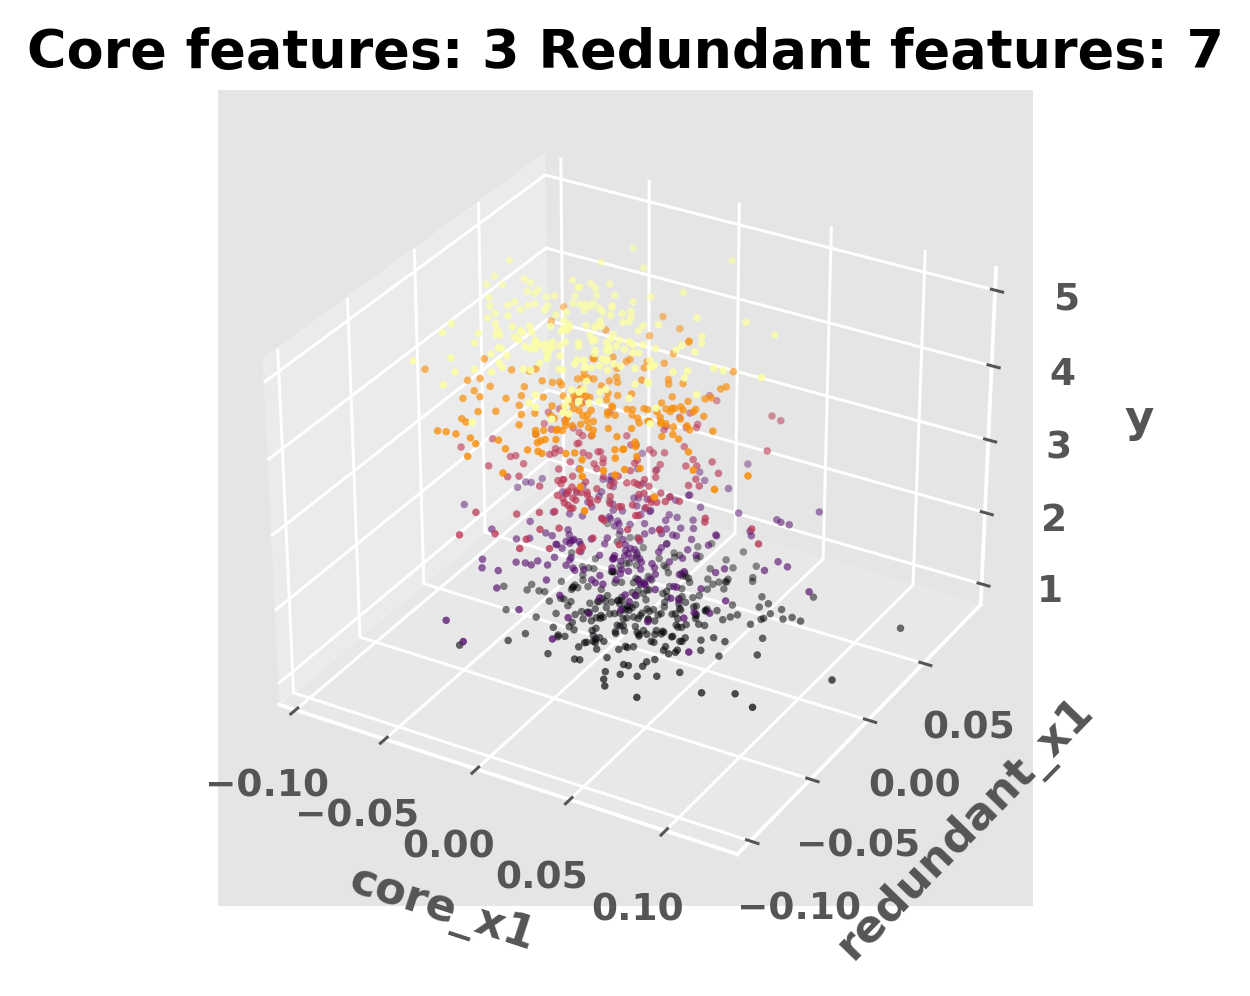

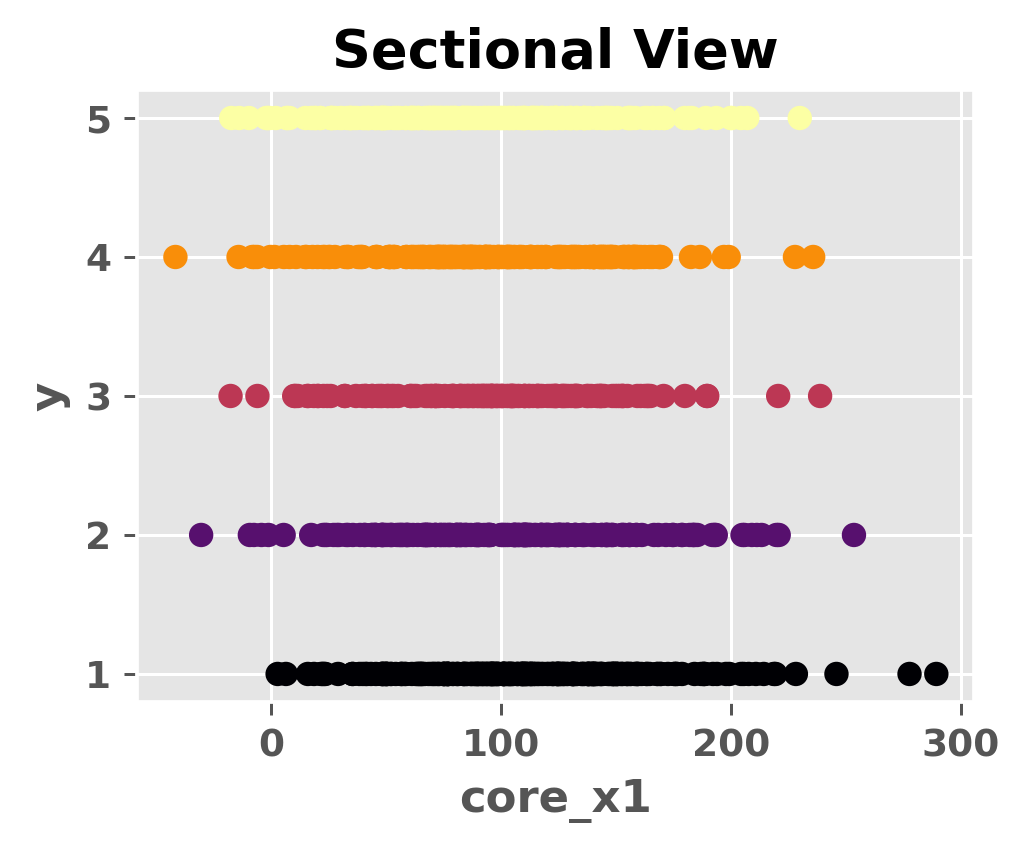

-------------------------------------------------------------------
Directions: 
[[-0.18477844 -0.46305444 -0.86152502  0.06977021  0.05126109 -0.03897537
  -0.00385895  0.00692841  0.01155968 -0.00098056]
 [ 0.05239772  0.02201542 -0.06825817 -0.43824988 -0.06233702  0.23912818
  -0.55588284  0.35239672  0.01020877  0.55288885]
 [-0.40928935 -0.02088252  0.10342363  0.09008566 -0.47270911 -0.36209001
   0.00435937  0.04916185  0.64871053  0.18817532]
 [ 0.30562488 -0.25108531  0.12732238  0.38701368  0.41771903  0.1261246
   0.25347728  0.46992983  0.37726806  0.24443087]
 [-0.18391086 -0.43317814  0.26822885 -0.43213835  0.16736682 -0.43985129
   0.03648691  0.42087809 -0.18319423 -0.29382415]
 [ 0.68167535 -0.42919258  0.07494964  0.0608792  -0.42123699 -0.2903805
  -0.11505541 -0.21571729 -0.08839854  0.11154056]
 [-0.14522502 -0.44132813  0.21617322 -0.39815796  0.04804964  0.43499925
   0.34371971 -0.45195658  0.16957488  0.19021517]
 [ 0.04966669  0.277357   -0.14702026 -0.20032

In [152]:
feature_df_reduced, feature_df_whitened, label_df = sanity_check(core_dirs = 3, redundant_dirs = 7, n_directions = 10, loc = 20, scale = 10)

In [161]:
np.random.seed(531)
test_X = np.random.randn(1000, 10)
y = np.random.choice([1,2,3,4,5], 1000)
y = pd.DataFrame(data = y, columns = ['columns'])

In [162]:
post_process(
    test_X, 
    y, 
    flag = "Train", 
    method = my_SAVE, 
    add_predictors = False, 
    n_directions = 3
)

Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 10)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [151]:
basis = directions[:3,:]
print(np.linalg.matrix_rank(basis))
basis

2


array([[-0.9998149 ,  0.01923969],
       [ 0.01923969,  0.9998149 ]])

#### Baseline Logistic Regression

In [73]:
def my_lr(feature_df, label_df):
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, accuracy_score

    feature_df_train, feature_df_test, label_df_train, label_df_test = train_test_split(
        feature_df, label_df, 
        shuffle = True, 
        random_state = 42
    )

    lr = LogisticRegressionCV(
        Cs = 10, 
        cv = 5, 
        penalty = 'l2', 
        dual = False, 
        max_iter = 100, 
        n_jobs = -1, 
        verbose = 0, 
        multi_class = 'auto', 
        random_state = 42
    )
    lr.fit(feature_df_train, np.array(label_df_train).ravel())
    lr_pred = lr.predict(feature_df_test)
    lr_f1 = f1_score(y_true = label_df_test, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = label_df_test, y_pred = lr_pred)
    print('-------------------------------------------------------------------')
    print(f'Baseline\nAccuracy: {lr_accu:8.4f}\nF1-score: {lr_f1:8.4f}')
    pass

In [74]:
my_lr(feature_df_whitened, label_df)

-------------------------------------------------------------------
Baseline
Accuracy:   0.3840
F1-score:   0.2026


#### Reduced Logistic Regression

In [75]:
my_lr(feature_df_reduced, label_df)

-------------------------------------------------------------------
Baseline
Accuracy:   0.3520
F1-score:   0.1834


#### Learning curve with n_directions

In [94]:
def plot_learning_curve(n_directions_list, training_score_list, validation_score_list, metric_name, x_name, title, x_scale = "linear", save = False, filepath = "", filename = ""):
    '''
    Input: x-axis (e.g. PCA directions kept / n_estimators / max_depth)
           metric_name for y-axis (e.g. misclassification error / crossentropy error / accuracy / f1 score)
           title for this axis
           training + validation score in list
           default in linear scale
           default no saving files, if save is True, then have to specify filename and file path
    Output: inline display of the learning curve
    '''
    import pandas as pd
    import numpy as np  
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import cm
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    fig,ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.plot(n_directions_list, training_score_list, 'o-', label = "F1 score", linewidth = 2)
    ax.plot(n_directions_list, validation_score_list, 'o-', label = "Accuracy score", linewidth = 2)
    ax.legend()
    ax.set_xscale(x_scale)
    ax.set_title('Learning Curve: ' + title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(metric_name)
    ax.hlines(0.3840)
    ax.hlines(0.2026)
    plt.show()
    if save:
        fig.savefig(filepath + filename + ".png", format = "png")
    pass

In [90]:
# generate feature_df for reuse
import pandas as pd
import numpy as np
import re
import os
import random
core_dirs = 3
redundant_dirs = 7
size = 1000
core_distribution = np.random.normal
core_feature_df = pd.DataFrame(data = None)
for i in np.arange(core_dirs):
    core_feature_df = pd.concat(
        [
            core_feature_df, 
            pd.Series(core_distribution(size = size, loc = 20, scale = 10,) * (np.random.randint(10) + 5))
        ], 
        axis = 1
    )
core_coef = np.random.random(size = core_dirs) * 0.1
y_train = np.sin(0.2 * np.asarray(core_feature_df) @ core_coef) * 5 + np.random.random(size = size)   
y_train_discrete = pd.cut(y_train, bins = 5, labels=np.arange(5) + 1).astype(int)
redundant_feature_df = pd.DataFrame(data = None)
for i in np.arange(redundant_dirs):
    redundant_feature_df = pd.concat(
        [
            redundant_feature_df, 
            pd.Series(np.random.random(size = size) * (np.random.randint(10) + 5))
        ], 
        axis = 1
    )
syncthetic_feature_df = pd.concat([core_feature_df, redundant_feature_df], axis = 1)
syncthetic_label_df = pd.DataFrame(y_train_discrete, columns = ["label"])

In [157]:
import sliced
from sliced import SlicedAverageVarianceEstimation
save_alt = SlicedAverageVarianceEstimation(
    n_directions = 3, 
    n_slices = 5
)
save_alt.fit(syncthetic_feature_df, syncthetic_label_df)
print(save_alt.directions_)

NameError: name 'DataConversionWarning' is not defined

In [93]:
n_directions_list = list(np.arange(1, 11, dtype = int))
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

f1_list = []
accu_list = []

# train loop
for n_direction in n_directions_list:
    globals()['feature_df_reduced_' + str(n_direction)], _ = post_process(
        syncthetic_feature_df , 
        syncthetic_label_df, 
        flag = "Train", 
        method = my_SAVE, 
        add_predictors = False, 
        n_directions = n_direction
    )
    globals()['lr_' + str(n_direction)] = LogisticRegressionCV(
        Cs = 10, 
        cv = 5, 
        penalty = 'l2', 
        dual = False, 
        max_iter = 100, 
        n_jobs = -1, 
        verbose = 0, 
        multi_class = 'auto', 
        random_state = 42
    )
    globals()['lr_' + str(n_direction)].fit(globals()['feature_df_reduced_' + str(n_direction)], np.array(syncthetic_label_df).ravel())
    lr_pred = globals()['lr_' + str(n_direction)].predict(globals()['feature_df_reduced_' + str(n_direction)])
    lr_f1 = f1_score(y_true = syncthetic_label_df, y_pred = lr_pred, average = 'macro')
    lr_accu = accuracy_score(y_true = syncthetic_label_df, y_pred = lr_pred)
    f1_list.append(lr_f1)
    accu_list.append(lr_accu)
    print('-------------------------------------------------------------------')
    print(f'Baseline\nAccuracy: {lr_accu:8.4f}\nF1-score: {lr_f1:8.4f}')
    

Exception reporting mode: Plain
-------------------------------------------------------------------
Shape of feature df before post processing: (1000, 10)
-------------------------------------------------------------------
Class label 1:
(I - V)^2 eigenvalues: [0.99855328 0.9984101  0.99832959 0.99821645 0.99810111 0.99787905
 0.99774451 0.99772249 0.99763866 0.99697425]
-------------------------------------------------------------------
Class label 2:
(I - V)^2 eigenvalues: [0.99887045 0.9986513  0.99853457 0.99836697 0.9980622  0.99792869
 0.99778505 0.99747691 0.99742416 0.99713462]
-------------------------------------------------------------------
Class label 3:
(I - V)^2 eigenvalues: [0.99870673 0.99863109 0.99841286 0.99820415 0.99805652 0.99789927
 0.99763291 0.99756261 0.99752346 0.99695606]
-------------------------------------------------------------------
Class label 4:
(I - V)^2 eigenvalues: [0.99859854 0.99853173 0.99838633 0.99815557 0.99802763 0.99795842
 0.99779172 0.9

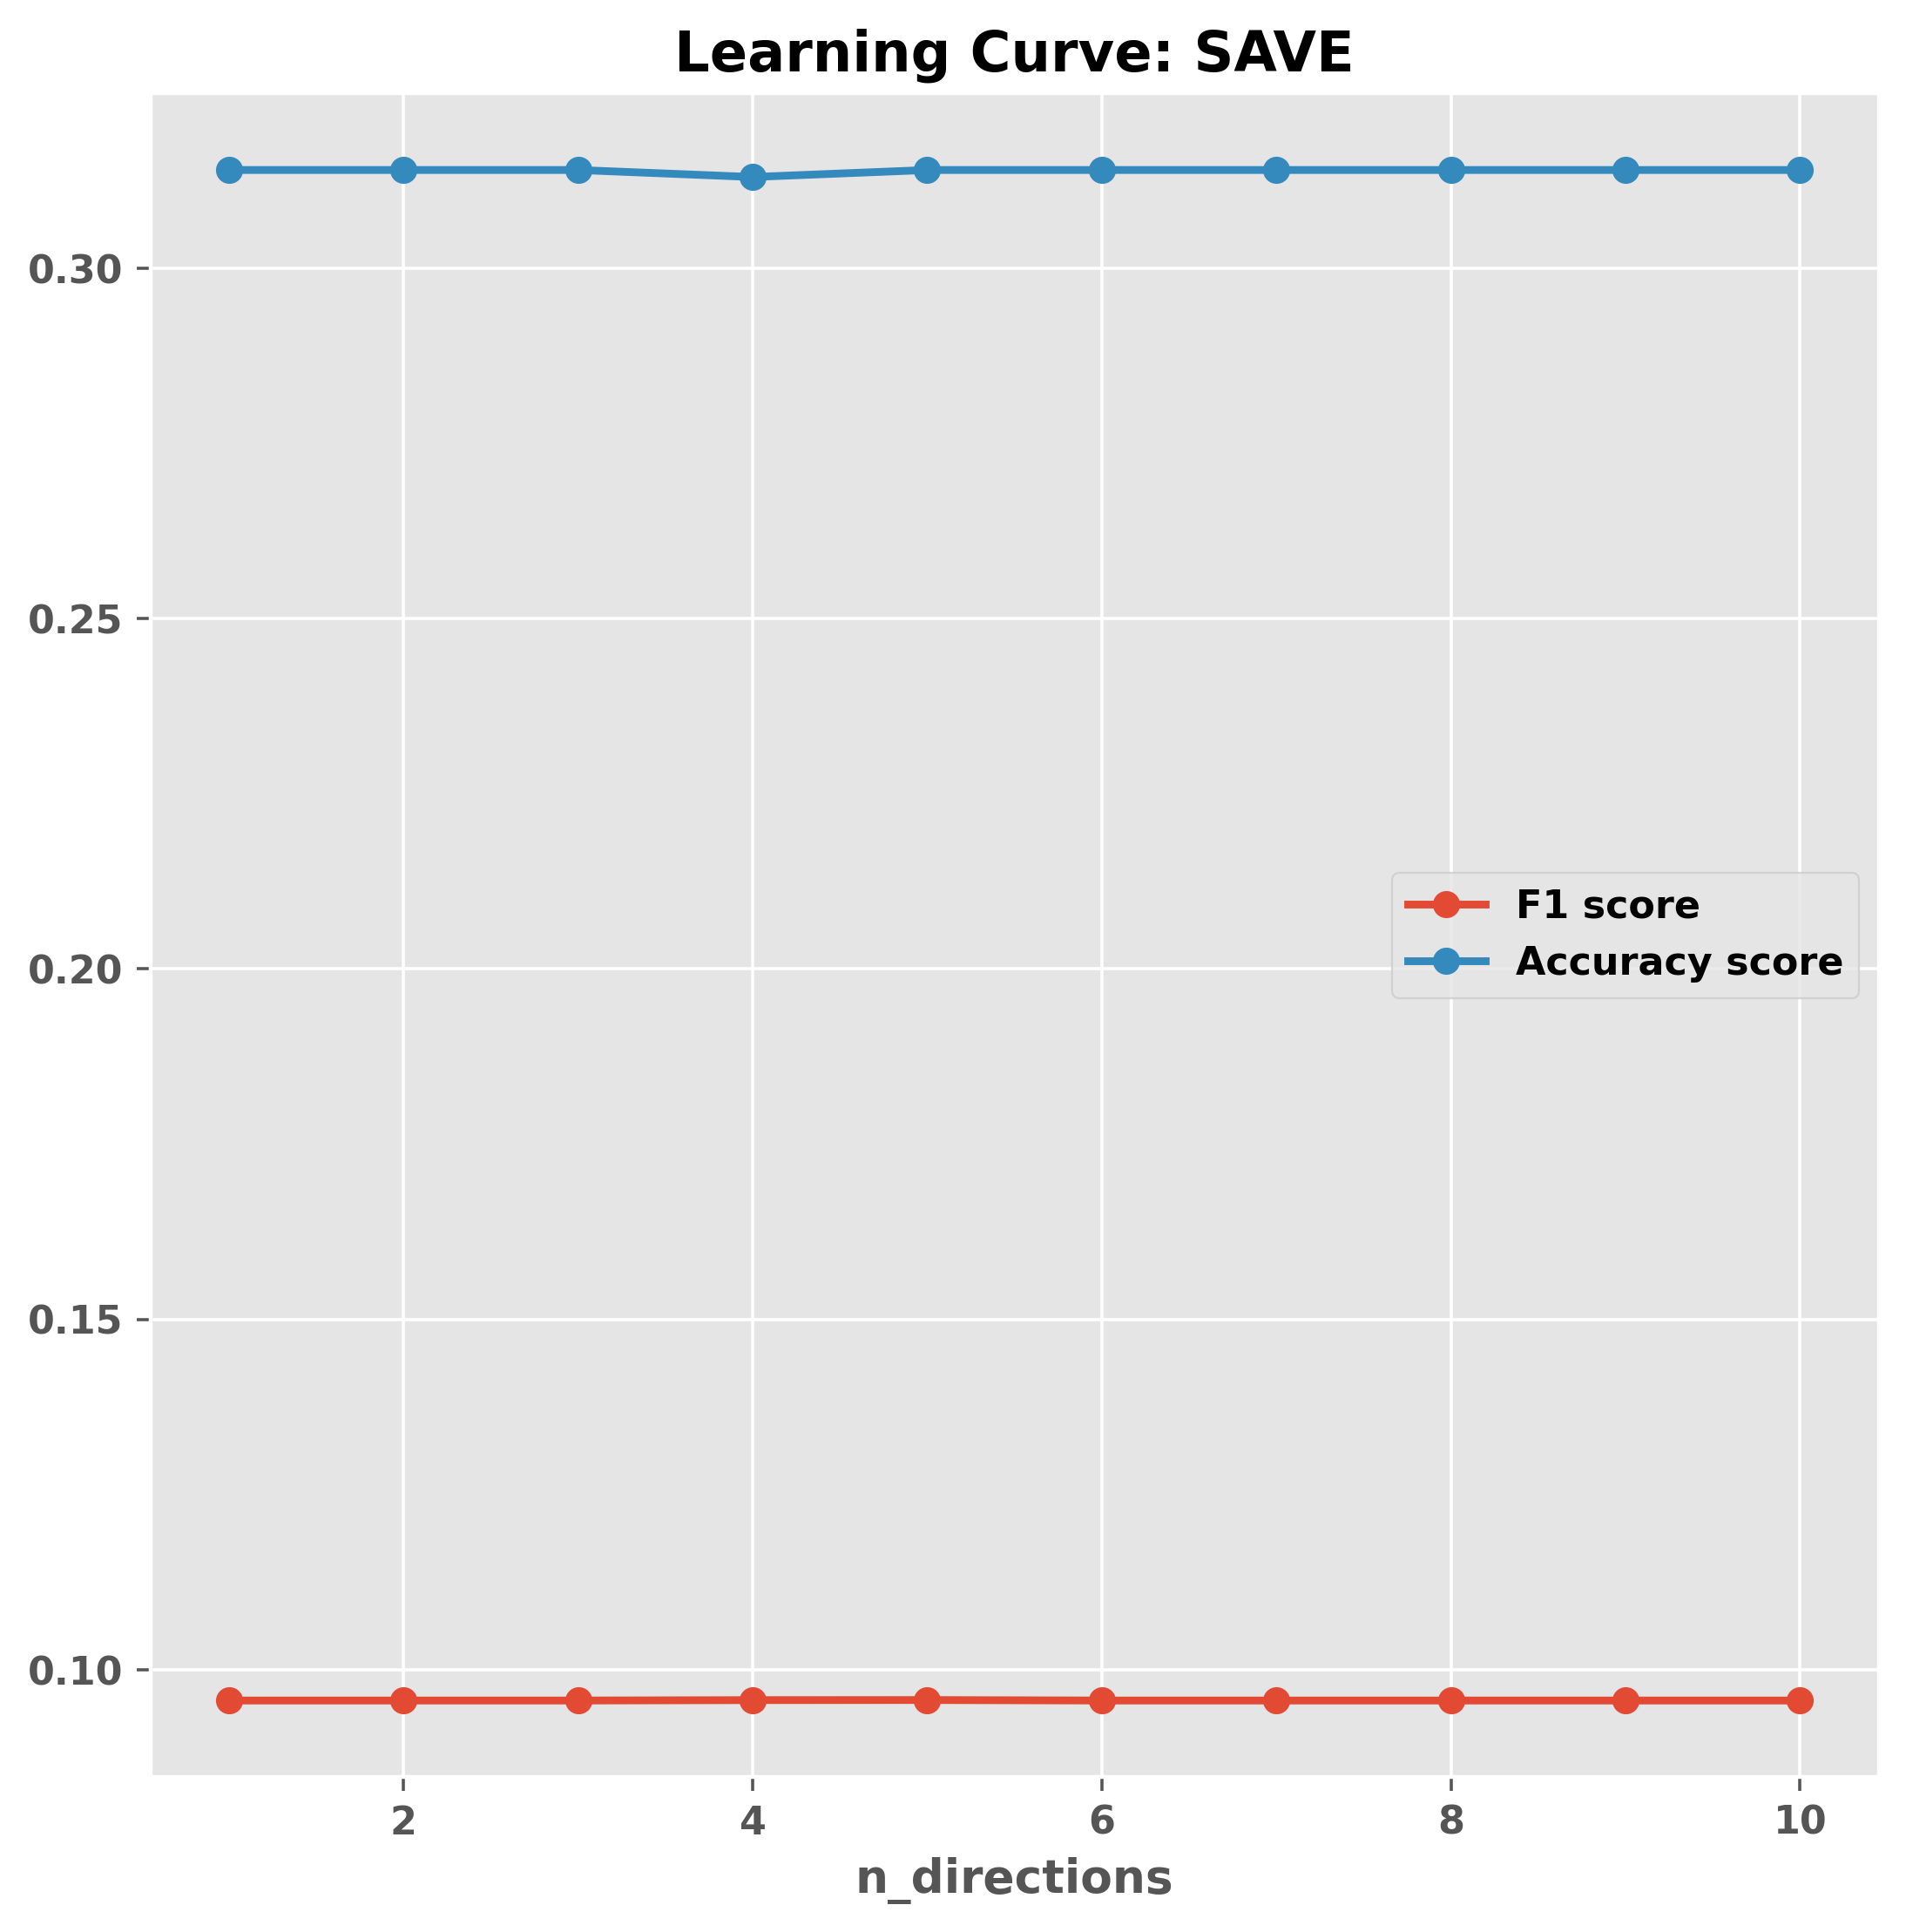

In [150]:
plot_learning_curve(
    n_directions_list = n_directions_list, 
    training_score_list = f1_list, 
    validation_score_list = accu_list, 
    metric_name = "", 
    x_name = "n_directions", 
    title = "SAVE"
)